In [2]:
# From "A Theoretical Model for Computing Freezing Point Depression of Lithium-Ion Battery Electrolytes"
# Self et al. 2021, DOI: 10.1149/1945-7111/ac3e47/
# MD Analysis Imports
import MDAnalysis as mda
# Standard Imports
import numpy as np, matplotlib.pyplot as plt, pandas as pd, csv, scipy.fftpack, statsmodels.tsa.stattools, re
from scipy import stats, integrate
from matplotlib import colors as col
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook
# Where am I?
#!pwd
#!ls
import seaborn as sns
color_pal = sns.color_palette("colorblind", 6).as_hex()

In [3]:
############################################################################
##### DH-type act coeff to correct for non-idealities in KA ################
############################################################################
#def ySqdh(IS,Adh,z,Bdh,alphadh): #Activity coeff squred of free ion for 1-1, y_DH,+ * y_DH,-
#    return 10**(-2*Adh*np.abs(zplus*zminus)*np.sqrt(IS)/(1+Bdh*alphadh*np.sqrt(IS)))
def Adh(eps1,rho):
    #F^2e*sqrt(2)/(8 pi(eps_0 eps RT)^3/2)*sqrt(rho): 816.788 sqrt(L/mol) if eps =1
    #Calculates Adh debye huckel term
    #:param eps1: [float], dielectric constant of electrolyte.
    #:param rho: [float], density of neat solvent in kg/L.
    #:return: [float], scalar for Adh.
    '''
    This is a test:
    >>> (np.abs(Adh(78.3,0.9982)-1.1762)<0.01)==True & (np.abs(Adh(35.92,1.0)-1.6465*2.303)<0.01)==True
    True
    '''
    return((2.303*354.46/(eps1)**1.5)*np.sqrt(rho))
def Bdh(eps1,rho):
    # F/(eps0*eps*RT/2)^0.5 units of 1/nm*sqrt(L/mol)
    #Calculates Bdh debye huckel term
    #:param eps1: [float], dielectric constant of electrolyte.
    #:param rho: [float], density of neat solvent in kg/L.
    #:return: [float], scalar for Bdh.
    '''
    This is a test:
    >>> (np.abs(Bdh(78.3,0.9982)-3.287)<0.01)==True & (np.abs(Bdh(35.92,1.0)-4.8596)<0.01)==True
    True
    '''
    return(29.1251/np.sqrt(eps1)*np.sqrt(rho))
def yDH(IS,z,eps1,alphadh,rho): #Activity coeff for one ion
    #Calculates DH activity coefficient for a charged species
    #:param IS: [float], ionic strength (molality)
    #:param z: [float], charge of species (e.g 1)
    #:param alphadh: [float], distance of closest approach in nm
    #:param rho: [float], density of neat solvent in kg/L.
    #:return: [float], scalar for yDH.
    '''
    This is a test:
    >>> ((np.abs(yDH(0.15,2,78.3,0.6,1)-0.357))<0.01) == True
    True
    '''
    return np.exp(-Adh(eps1,rho)*np.abs(z**2)*np.sqrt(IS)/(1+Bdh(eps1,rho)*alphadh*np.sqrt(IS)))
###############################################
######### For Born solvation term #############
##########  Accounts for One Ion ##############
###############################################
def yBorn(z,RBorn,eps0,eps):
    #prefact # nm # e^2/(8*pi*electric constant*0.0257 eV) # RBorn in nm
    #Calculates Born activity coefficient for a charged species
    #:param z: [float], charge of species (e.g 1)
    #:param Rborn: [float], born Radius in nm
    #:param eps: [float], density of neat solvent in kg/L.
    #:return: [float], scalar for yBorn.
    '''
    This is a test:
    >>> ((np.abs(0.0257*np.log(yBorn(1,0.0625,78.3,1))-11.36)<0.2) & (np.abs(0.0257*np.log(yBorn(1,0.213,81,1))-3.339)<0.01)) == True
    True
    '''
    return(np.exp(28.014*(z**2)/RBorn*(1.0/eps-1.0/eps0)))
#############################
### Free Solvent Loss #######
#############################
def yFSL(m0solvent,cCAT,nCAT,cCIP,nCIP,ni):
    #Calculates free solvent loss activity coefficient for a solvated species
    #:param m0solvent: [float], molality of neat solvent (m)
    #:param cCAT: [float], concentration of cationic species (m)
    #:param nCAT: [float], solvation number of of cationic species (unitless)
    #:param cCIP: [float], concentration of CIP species (m)
    #:param nCIP: [float], solvation number of of CIP species (unitless)
    #:return: [float], scalar for yFSL.
    ''' This is a test:
    >>> yFSL(10,0.5,5,0.5,4,5) > 0
    True
    '''
    return(((m0solvent-cCAT*nCAT-cCIP*nCIP)/m0solvent)**(-ni))
######################################
### solve c+ from KA for 1-1 elytes ##
######################################
def cplusfromKAandc11(KA,c):
    #calculates concentration of cations for 1-1 CIP equilibrum
    #:param KA: [float], equilibrum constant (1/m)
    #:param c: [float], stochiometric concentration of salt (m)
    #:return [float],scalar for ...
    '''
    This is a test:
    >>> ((1-cplusfromKAandc11(10,0.01)/0.01) > 0.08) & ((1-cplusfromKAandc11(10,0.01)/0.01) < 0.09)
    True
    '''
    cplus = (-1 + np.sqrt(1+4*KA*c))/(2.0*KA)
    return(cplus)

In [4]:
import doctest
doctest.testmod(verbose=True,exclude_empty=True)

Trying:
    (np.abs(Adh(78.3,0.9982)-1.1762)<0.01)==True & (np.abs(Adh(35.92,1.0)-1.6465*2.303)<0.01)==True
Expecting:
    True
ok
Trying:
    (np.abs(Bdh(78.3,0.9982)-3.287)<0.01)==True & (np.abs(Bdh(35.92,1.0)-4.8596)<0.01)==True
Expecting:
    True
ok
Trying:
    ((1-cplusfromKAandc11(10,0.01)/0.01) > 0.08) & ((1-cplusfromKAandc11(10,0.01)/0.01) < 0.09)
Expecting:
    True
ok
Trying:
    ((np.abs(0.0257*np.log(yBorn(1,0.0625,78.3,1))-11.36)<0.2) & (np.abs(0.0257*np.log(yBorn(1,0.213,81,1))-3.339)<0.01)) == True
Expecting:
    True
ok
Trying:
    ((np.abs(yDH(0.15,2,78.3,0.6,1)-0.357))<0.01) == True
Expecting:
    True
ok
Trying:
    yFSL(10,0.5,5,0.5,4,5) > 0
Expecting:
    True
ok
1 items had no tests:
    __main__
6 items passed all tests:
   1 tests in __main__.Adh
   1 tests in __main__.Bdh
   1 tests in __main__.cplusfromKAandc11
   1 tests in __main__.yBorn
   1 tests in __main__.yDH
   1 tests in __main__.yFSL
6 tests in 7 items.
6 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=6)

In [5]:
class electrolyte11:
    """
    Class for electrolyte properties
    """
    def __init__(self, NeatDensity, NeatPermittivity, zplus, zminus, rplus, rminus, rcip, KA0, CIPdincr, CATdincr, ANdincr, SNCAT, SNCIP, S0):
        #calculates concentration of cations for 1-1 CIP equilibrum
        #:param NeatDensity: [float], density (kg/L)
        #:param NeatPermittivity: [float], solvent permittivity (e.g. water is 78) (unitless)
        #:param zplus: charge number of free cation
        #:param zminus: charge number of free anion
        #:param rplus: radius of cation (nm)
        #:param rmins: born radius of anion (nm)
        #:param rcip: born radius of CIP (nm) not used in this model
        #:param KA0: infinite dilution association constant for 1-1 CIP equilibrium (1/m)
        #:param CIPdincr: dielectric increment per 1 mol of CIP speceies 
        #:param CATdincr: dielectric increment per 1 mol of free cation speceies 
        #:param ANdincr: dielectric increment per 1 mol of free anion speceies 
        #:param SNCAT: solvation numer of cation
        #:param SNCIP: solvation number of CIP
        #:param S0: neat solvent molality        
        #:returns electrolyte11 with its properties (speciation, dielectric constant and act coeff)
        # concentration range, here in molality $m$
        gridpoints=np.int(10e3)
        self.c_max = 1.1 # 1.2
        self.concentrations = np.logspace(-4,np.log10(self.c_max),gridpoints)
        print(self.concentrations)
        # user input declarations
        self.density,self.permittivity  = NeatDensity,NeatPermittivity # (density : g/cm^3)
        self.zplus,self.zminus = zplus, zminus
        self.rplus,self.rminus, self.rcip = rplus, rminus, rcip #(nm)
        self.KA0 = KA0*self.density #(1/M*kg/L=L/mol*kg/L=kg/mol=1/m)
        self.CIPdincr,self.CATdincr,self.ANdincr = CIPdincr,CATdincr,ANdincr # (1/m)
        self.SNCAT,self.SNCIP = SNCAT,SNCIP # number of solvent molecules bound per cation, CIP
        self.S0 = S0 # molality of neat solvent
        # act coeffs calculation declarations
        self.eps_all,self.KA_all,self.ionicstrength_all = [],[],[]
        # free solvent number
        self.y_sDOF_plus,self.y_sDOF_cip  = [], []
        # speciation
        self.c_cip_all,self.c_plus_all,self.c_minus_all = [],[],[] # pop of cip,# pop of cations,# pop of anions
        # bookkeeping 
        self.y_total_oneIon,self.y_cation,self.y_anion, self.y_CIP = [],[],[],[]
        # freezing point depression
        self.osmoticcoefficient,self.solventactivity,self.liquidus = [],[],[]
    def get_actcoeff(self):
        for i in tqdm_notebook(range(len(self.concentrations))):
            c = self.concentrations[i]
            if i<50:
                eps1=self.permittivity
            else:
                eps1=np.average(self.eps_all[-50:-1])
            if i==0:
                ionicstrength= c
                #Solvation number effects          
                yDOFplus, yDOFcip = 1.0, 1.0
            else:
                ionicstrength=0.5*self.c_plus_all[-1]*self.zplus**2+0.5*self.c_minus_all[-1]*self.zminus**2
                #Solvation number effects          
                yDOFplus=yFSL(self.S0,self.c_plus_all[-1],self.SNCAT,self.c_cip_all[-1],self.SNCIP,self.SNCAT)
                yDOFcip=yFSL(self.S0,self.c_plus_all[-1],self.SNCAT,self.c_cip_all[-1],self.SNCIP,self.SNCIP)
            # compute DH parameters
            alphadh1=(self.rminus+self.rplus)
            yDHplus=yDH(ionicstrength,self.zplus,eps1,alphadh1,self.density)
            yDHminus=yDH(ionicstrength,self.zminus,eps1,alphadh1,self.density)
            # compute Born solvation parameters
            yBornPlus=yBorn(self.zplus,self.rplus,self.permittivity,eps1)
            yBornMinus=yBorn(self.zminus,self.rminus,self.permittivity,eps1)
            yCIP=yDOFcip#*yBorn(self.zplus,self.rcip,self.permittivity,eps1)
            # compute "concentration" equilibrium constant
            KA=(self.KA0)*(yDHplus*yDHminus*yBornPlus*yBornMinus*yDOFplus)/yCIP
            # solve mass action for ion pairing
            if self.zplus+self.zminus==2: # 1-1 elyte   
                c_plus = cplusfromKAandc11(KA,c)
                c_cip = c - c_plus # mass conservation
                c_minus = c_plus # electroneutrality
            else:
                print('error')
            # compute dielectric constant
            if i==0:
                eps1 = self.permittivity
            else:
                eps1 = self.permittivity+c_cip*self.CIPdincr+c_plus*self.CATdincr+c_minus*self.ANdincr
            #
            self.c_cip_all.append(c_cip)
            self.c_plus_all.append(c_plus)
            self.c_minus_all.append(c_minus)
            self.eps_all.append(eps1)
            self.KA_all.append(KA)
            self.ionicstrength_all.append(ionicstrength)
            self.y_cation.append(yBornPlus*yDHplus*yDOFplus)
            self.y_anion.append(yBornMinus*yDHminus)
            self.y_CIP.append(yCIP)
            self.y_sDOF_cip.append(yDOFcip)
            self.y_sDOF_plus.append(yDOFplus)
        #
        self.c_cip_all,self.c_plus_all=np.array(self.c_cip_all),np.array(self.c_plus_all)
        self.eps_all=np.array(self.eps_all)
        self.y_cation,self.y_anion,self.y_CIP=np.array(self.y_cation),np.array(self.y_anion),np.array(self.y_CIP)
        # compute thermodynamic properties
        self.y_total_oneIon=np.sqrt(self.y_cation*self.y_anion)# not one + or  one - but one "free +-" (i.e. \gamma+- = \gamma-+)
        muCIP = 0.0257*np.log((self.c_cip_all*self.y_CIP)/(self.KA0))
        muCATION = 0.0257*(np.log(self.y_cation*self.c_plus_all))
        muANION = 0.0257*(np.log(self.y_anion*self.c_minus_all))
        self.mu_all = muCATION*self.c_plus_all/self.concentrations 
        self.mu_all += muCIP*self.c_cip_all/self.concentrations
        self.mu_all += muANION*self.c_minus_all/self.concentrations
        self.y_total = 1/self.concentrations*np.exp(self.mu_all/(2*0.0257)) # y_pm

In [6]:
########## defining numerical derivative #################
def diff_central(a, b):
    xdc0 = a[:-2]
    xdc1 = a[1:-1]
    xdc2 = a[2:]
    ydc0 = b[:-2]
    ydc1 = b[1:-1]
    ydc2 = b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
########### Osmotic Coefficient from Act Coeff ###################
def ComputeOsmotic(ConcArrayIn,yArrayIn):
    '''
    This is a test:
    >>> (ComputeOsmotic(np.linspace(0.0001,1,10000),1+np.array(np.linspace(0.0001,1,10000))**2))[-1]
    1.429232454717847
    '''
    td_factor = diff_central(np.log(ConcArrayIn),np.log(yArrayIn))+1
    td_factor=np.nan_to_num(td_factor[:],1) ### remove NAN
    osmotic_coeff = 1 + (1/ConcArrayIn[:-3])*integrate.cumtrapz(td_factor-1,ConcArrayIn[:-2])
    return(np.append([1,1,1],osmotic_coeff))
############ Activity of Solvent from Osm Coeff #############################
def ComputelnActSolvent(ConcArrayIn,OsmCoeffIn,MolarMass):
    #e.g. MolarMass=0.08806 #kg/mol (of solvent)
    '''
    This is a test:
    >>> (ComputelnActSolvent(np.array([1]),np.array([1]),0.0180153) == -0.0360306)[0]
    True
    '''
    lnSolventActivity=-OsmCoeffIn*2*ConcArrayIn[:len(OsmCoeffIn)]*MolarMass
    return(lnSolventActivity)
######## Liquidus from Activity of Solvent ###########
#T0=308.5 # Kelvin,H0=13.295 # kJ/mol,CP=16.73*0.001 # J/mol K * 0.001 = kJ/mol K,R=0.001*8.31 # kJ/K
def liquidus(T0,H0,dCP,concentrations,lnSolventAct):
    '''
    This is a test:
    >>> #(ComputelnActSolvent(np.array([1/1.32]),np.array([1.5]),0.08806)) # array([-0.20013636])
    >>> liquidus(308.5,13.295,16.73*0.001,np.array([1.0/1.32]),np.array([-0.20013636]))[0] #23.802929005392457 Celsius
    23.802929005392457
    '''    
    R=8.31*0.001
    def templow():
        num=H0-2*R*T0*lnSolventAct[:]-np.sqrt(2*dCP*T0**2*R*lnSolventAct[:]+H0**2)
        denom=2*(H0/T0+0.5*dCP-R*lnSolventAct[:])
        return(T0-num/denom)
    return(templow()-273.15)
########## Solvent Activity from Liquidus ####################
def lnActSolvFromLiquidus(T0,H0,dCP,concentrations,liquidus):
    theta=T0-(liquidus+273.15)
    lnSolventActivity=1/(8.31*0.001)*(H0*(1/T0-1/(T0-theta))+0.5*dCP*(theta/(T0-theta))**2)
    return(lnSolventActivity)
############ Osm Coeff from Solvent Activity #############################
def ComputeOsmoticFromlnActSolvent(ConcArrayIn,lnSolventActivityIn,MolarMass):
    OsmCoeffOut=-lnSolventActivityIn/(2*np.array(ConcArrayIn[:len(lnSolventActivityIn)])*MolarMass)
    return(OsmCoeffOut)
############# Salt Activity from Osmotic Coefficient #####################
def ComputeGammafromOsmotic(conc,osm):
    inttemp=diff_central(conc,conc*(osm-1))
    temp2=integrate.cumtrapz(inttemp/conc[:-2],conc[:-2])
    return(conc[3:],temp2)
########## TD factor from lny #########
def TDfactorfromLnY(conc,lny):
    return(1+diff_central(np.log(conc),lny))

In [7]:
# Electrolyte (density,neateps,z1,z2,rplus,rminus,rCIP,KA0,depsCIP,depsCAT,depsAN, SolvNCation, SolvNumbCIP, S0)
# Electrolyte (g/cm^3, [], [], [], nm, nm, nm, /M, [], [], [])
#### USER INPUT HERE #####
LiPF6DMC=electrolyte11(1.07,3.11,1,1,0.404,0.31,0.71,3.48*10**(16),23.24,2.87,1.19, 5, 4, 11.1)
LiPF6DMC.get_actcoeff()

[1.00000000e-04 1.00093109e-04 1.00186305e-04 ... 1.09795446e+00
 1.09897675e+00 1.10000000e+00]


/var/folders/rp/vvcf442x0z15366z01pjwp100000gp/T/ipykernel_15292/571034926.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gridpoints=np.int(10e3)
/var/folders/rp/vvcf442x0z15366z01pjwp100000gp/T/ipykernel_15292/571034926.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(self.concentrations))):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
#Experimental data for LiPF6 in DMC
mOsmExpLiPF6=[0,0.035,0.078,0.113,0.235,0.341,0.48,0.59,0.703,0.814,0.960,1.100,1.235,1.563,1.799,1.902,2.015,2.148,2.378]
OsmExpLiPF6=[1,0.514,0.452,0.409,0.358,0.338,0.325,0.316,0.315,0.316,0.317,0.330,0.351,0.382,0.423,0.438,0.459,0.482,0.508]
GammaExpLiPF6=[1,0.033,0.021,0.016,0.010,0.007,0.006,0.005,0.004,0.004,0.004,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003]

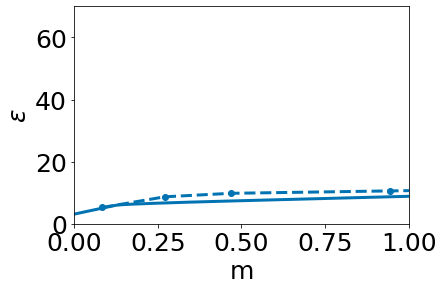

In [9]:
plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=25)
plt.plot(LiPF6DMC.concentrations, LiPF6DMC.eps_all,'-',color=color_pal[0], label='LiPF$_6$ in DMC (Comp)')
# Experimental
plt.plot(np.array([0.09,0.29,0.5,1.01,2.00])/LiPF6DMC.density,[5.26,8.69,9.81,10.59,12.06],'--o',color=color_pal[0])
plt.ylabel(r'$\epsilon$'), plt.xlabel('m')
plt.xlim(0,1), plt.ylim(0,70)
plt.rc('savefig',dpi=300)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
# plt.savefig('Permittivity.pdf',bbox_inches="tight",transparent=True)

(Text(0.5, 0, 'm'), Text(0, 0.5, '$m_+/m$'))

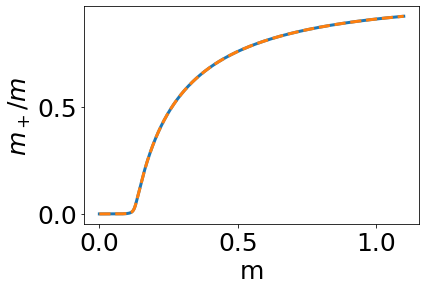

In [10]:
plt.plot(LiPF6DMC.concentrations,(LiPF6DMC.y_total/LiPF6DMC.y_total_oneIon))
plt.plot(LiPF6DMC.concentrations,(LiPF6DMC.c_plus_all/LiPF6DMC.concentrations),'--')
plt.xlabel('m'), plt.ylabel(r'$m_+/m$')
# TEST
# y+- = alpha * y+-_freeion : plots should be overlapping (Marcus and Hefter 2006, Chem Rev, 106, eq. 55)

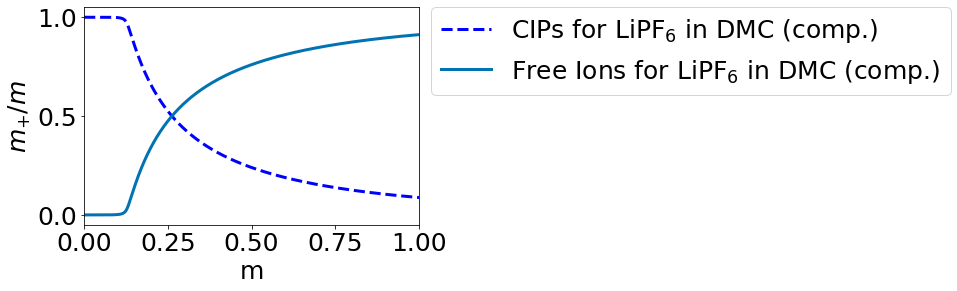

In [11]:
plt.plot(LiPF6DMC.concentrations[:],1-LiPF6DMC.c_plus_all/LiPF6DMC.concentrations[:],'--b', label='CIPs for LiPF$_6$ in DMC (comp.)')
plt.plot(LiPF6DMC.concentrations[:],LiPF6DMC.c_plus_all/LiPF6DMC.concentrations[:],color=color_pal[0], label='Free Ions for LiPF$_6$ in DMC (comp.)')
plt.xlabel(r'm'), plt.ylabel('$m_{+}/m$'), plt.xlim([0,1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
plt.rc('savefig',dpi=300)
#plt.savefig('Speciation.pdf',bbox_inches="tight",transparent=True)

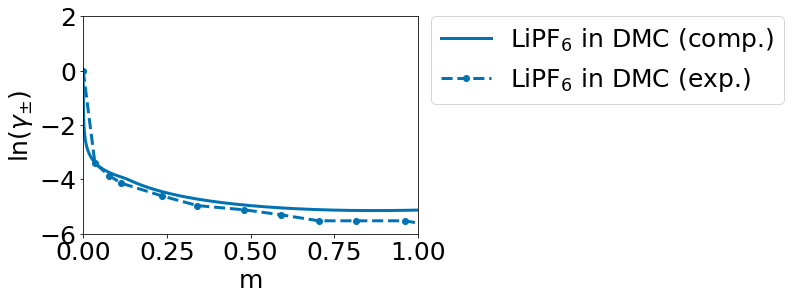

In [12]:
# Model here
offset=0
plt.plot(LiPF6DMC.concentrations[:],np.log(LiPF6DMC.y_total[:])+14,color=color_pal[0], label='LiPF$_6$ in DMC (comp.)')
# Experimental
plt.plot(mOsmExpLiPF6,np.log(GammaExpLiPF6),'--o',color=color_pal[0],label='LiPF$_6$ in DMC (exp.)')
# Plotting
plt.ylabel('ln($\gamma_{\pm}$)'), plt.xlabel(r'm')#$^{0.5}$')
plt.xlim(0,1), plt.ylim([-6,2.0]), #plt.grid('on')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
#plt.rc('savefig',dpi=300)
#plt.savefig('lngamma.pdf',bbox_inches="tight",transparent=True)
plt.show()

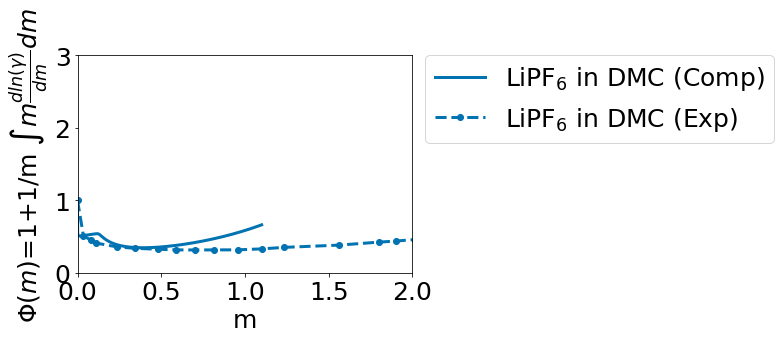

In [13]:
# Computed
LiPF6DMC.osmoticcoefficient=ComputeOsmotic(LiPF6DMC.concentrations[:],LiPF6DMC.y_total[:])
plt.plot(LiPF6DMC.concentrations[:],(LiPF6DMC.osmoticcoefficient[:]),color=color_pal[0], label='LiPF$_6$ in DMC (Comp)')
# Experimental
plt.plot(mOsmExpLiPF6,(OsmExpLiPF6),'--o',color=color_pal[0],label='LiPF$_6$ in DMC (Exp)')
###
plt.ylabel(r'$\Phi(m)$=1+1/m $\int m \frac{dln(\gamma)}{dm}dm$'), plt.xlabel(r'm')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
plt.xlim(0,2), plt.ylim(0,3)
plt.rc('savefig',dpi=300)
#plt.savefig('osmotic.pdf',bbox_inches="tight")
plt.show()

/var/folders/rp/vvcf442x0z15366z01pjwp100000gp/T/ipykernel_15292/1317977799.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--ob" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mOsmExpLiPF6[:],np.array(LiPF6DMCExpsolventactivity),'--ob',color=color_pal[0],label='exp.')


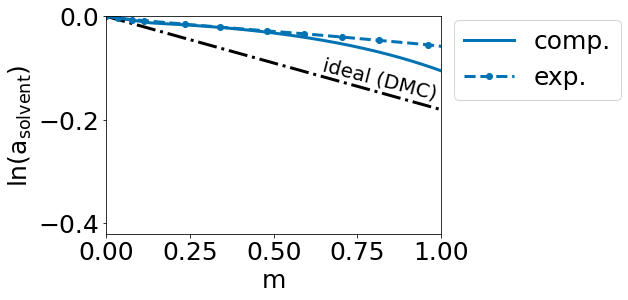

In [14]:
MolarMassOfDMC, MolarMassOfPC=0.09008,0.10209  # kg/mol
LiPF6DMC.solventactivity=ComputelnActSolvent(LiPF6DMC.concentrations[:],LiPF6DMC.osmoticcoefficient,MolarMassOfDMC)
#
DMCIdealActivity=ComputelnActSolvent(LiPF6DMC.concentrations[:],LiPF6DMC.osmoticcoefficient*0+1,MolarMassOfDMC)
#
plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=25)          # controls default text sizes
plt.plot(LiPF6DMC.concentrations[:],LiPF6DMC.solventactivity,color=color_pal[0],label='comp.')
plt.plot(LiPF6DMC.concentrations[:],DMCIdealActivity,'-.',color='black')
# experimental values
LiPF6DMCExpsolventactivity=ComputelnActSolvent(mOsmExpLiPF6[:],np.array(OsmExpLiPF6),MolarMassOfDMC)
plt.plot(mOsmExpLiPF6[:],np.array(LiPF6DMCExpsolventactivity),'--ob',color=color_pal[0],label='exp.')
plt.xlabel(r'm'), plt.ylabel(r'ln(a$_\mathrm{solvent}$)')
plt.xlim([0,1]), plt.ylim([-0.42,0])
plt.rc('savefig',dpi=300)
plt.text(0.64,-0.16,"ideal (DMC)",rotation=-14.4,fontsize='20')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
#plt.savefig('lnactivitysolvent.pdf',bbox_inches="tight",transparent=True)

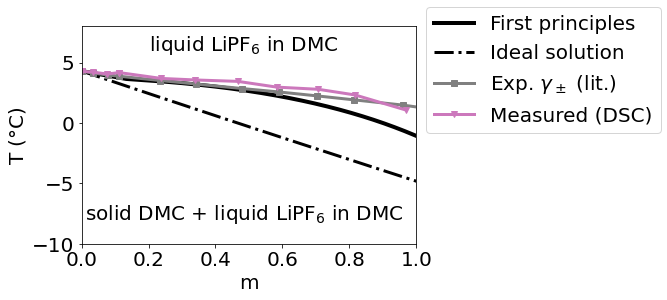

In [17]:
TmDMC=273.15+4.3 # in degrees
HfusDMC=12.36 # (kJ/mol)
CPDMC=29*0.001 # (J/(mol K) * 0.001 = kJ/(mol K))
LiPF6DMC.liquidus=liquidus(TmDMC,HfusDMC,CPDMC,LiPF6DMC.concentrations,LiPF6DMC.solventactivity)
plt.rc('font', size=20)          # controls default text sizes
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('m'),ax1.set_ylabel(r'T ($\degree$C)'),ax1.set_xlim([0,1.0]),ax1.set_ylim([-10,8])
#
plt.text(0.2,6,"liquid LiPF$_6$ in DMC")
plt.text(0.01,-8,"solid DMC + liquid LiPF$_6$ in DMC")
#
ax1.plot(LiPF6DMC.concentrations[:],LiPF6DMC.liquidus,'-k',linewidth='4',label='First principles')
# ideal
templnasIdeal=ComputelnActSolvent(LiPF6DMC.concentrations[:],LiPF6DMC.osmoticcoefficient*0+1,MolarMassOfDMC)
templiquidusIdeal=liquidus(TmDMC,HfusDMC,CPDMC,LiPF6DMC.concentrations,templnasIdeal)
ax1.plot(LiPF6DMC.concentrations[:],templiquidusIdeal,'-.',color='black',label='Ideal solution')
# exp
plt.plot(mOsmExpLiPF6[:],liquidus(TmDMC,HfusDMC,CPDMC,mOsmExpLiPF6[:],np.array(LiPF6DMCExpsolventactivity)),'-s',color='grey',label=r'Exp. $\gamma_\pm$ (lit.)')
#
######## DSC Measurements
MeasC=np.array([0,0,0.035,0.077,0.112,0.112,0.238,0.338,0.467,0.583,0.707,0.817,0.968])
MeasAverage=[4.285, 4.205, 4.055, 4.175, 4.175, 3.69 , 3.565, 3.445, 2.97 , 2.79 , 2.32 , 1.08]
plt.plot(MeasC[1:],MeasAverage,'-v',color=color_pal[4],label='Measured (DSC)')
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
#
plt.rc('savefig',dpi=300)
#plt.savefig('LiPF6DMC.pdf',bbox_inches="tight",transparent=True)